In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor') #going up several files until emili_TimeSeriesPredictor
from time_series_predictor.Data.emotionFeatureExtractor import emotionFeatureExtractor
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

### **Generating Synthetic Data**

**Parameters**

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Sine function parameters
'''

'''

#Function parameters
nSines = 5 #Number of sines in the linear combination
amplitude_dist = (0, 1)  # Mean, Std for normal distribution
frequency_dist = (0, 1)  # Mean, Std for normal distribution
phase_dist = (0, 2 * np.pi)  # Min, Max for uniform distribution


#Supervise learning parameters
lookback = 600
forecast = 100
timesteps = 700 #each spaced delta_t apart
delta_t = 0.01 # time between samples
assert timesteps == lookback + forecast

nFunctions = 1000
noise_lvl = 0

print(f'Time between each sample is {delta_t}')
print(f'Number of seconds per function is {delta_t*(lookback+forecast)}')


Time between each sample is 0.01
Number of seconds per function is 7.0


**Generating Univariate Random Sine Functions**

$f_n(x) = \sum_{i=1}^k{A_{in}\sin({B_{in}x+C_{in}}})+\sigma*W_n(x)$
- $x = $ 0, 0.01, 0.02, ... timesteps-1/100 (x = time in seconds)
- $A_{in} $~$ N(0,1)$
- $B_{in} $~$ N(0,1)$
- $C_{in} $~$ Unif(0,2*\pi)$
- $W_n(x)$ = geometric brownian motion. $W_n(x) = \sum_{j=1}^x{\hat{Z_j}}$
- $\hat{Z_j}$ ~ $N(0,\sigma^2)$ i.i.d

(1000, 700, 1)


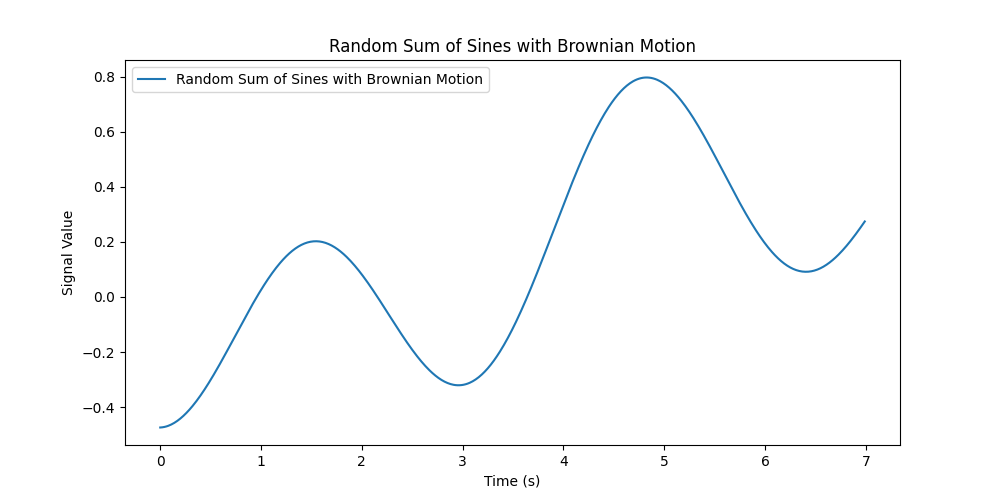

In [20]:
def generate_random_sines(n, k_sines, timesteps, delta_t, amplitude_dist, frequency_dist, phase_dist, noise_lvl = 0.01):
    """
    Generates n of random linear combinations of k_sines sine functions with added Brownian motion.

    Parameters:
    - n (int): Number of different functions to generate.
    - k_sines (int): Number of sine functions to combine in each sample.
    - timesteps (int): Total number of time steps in each sine wave.
    - delta_t (float): Time step interval.
    - amplitude_dist (tuple): Distribution parameters for amplitude (mean, std).
    - frequency_dist (tuple): Distribution parameters for frequency (mean, std).
    - phase_dist (tuple): Distribution parameters for phase shift (min, max).
    - noise_lvl (float): Size of GBM noise to add

    Returns:
    - t (numpy.ndarray): Array of timestamps for each value with shape (timesteps); each function has the same time start and end
    - data (numpy.ndarray): Array of generated sine waves with shape (n, timesteps).
    """
    data = []

    for _ in range(n): #creating n functions
        # Generate time array
        t = np.linspace(0, (timesteps - 1) * delta_t, timesteps)
        
        # Initialize signal as zero to sum over multiple sine components
        signal = np.zeros(timesteps)
        
        for _ in range(k_sines):
            # Generate random parameters for a single sine wave
            amplitude = np.random.normal(*amplitude_dist)
            frequency = np.random.normal(*frequency_dist)
            phase_shift = np.random.uniform(*phase_dist)

            # Add the sine component to the signal
            signal += amplitude * np.sin(frequency * t + phase_shift)

        # Add Brownian motion noise
        # Using additive noise here instead of exponential scaling
        brownian_motion = np.cumsum(np.random.normal(0, np.sqrt(delta_t), timesteps))
        signal += noise_lvl*brownian_motion
        
        # Store the generated signal with Brownian noise
        data.append(signal)

    return t, np.array(data)

t, data = generate_random_sines(n=nFunctions, 
                                   k_sines=nSines, timesteps=timesteps,
                                   delta_t=delta_t, 
                                   amplitude_dist=amplitude_dist, frequency_dist=frequency_dist, phase_dist=phase_dist,
                                   noise_lvl=noise_lvl)

#Convert so that data is in shape (nSamples,timesteps,features)
data = data[:,:,np.newaxis]
print(data.shape)

# Visualize one of the generated sine waves with Brownian noise
plt.close('all')
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(timesteps) * delta_t, data[0], label='Random Sum of Sines with Brownian Motion')
plt.xlabel("Time (s)")
plt.ylabel("Signal Value")
plt.title("Random Sum of Sines with Brownian Motion")
plt.legend()
plt.show()


**Train Test Split**

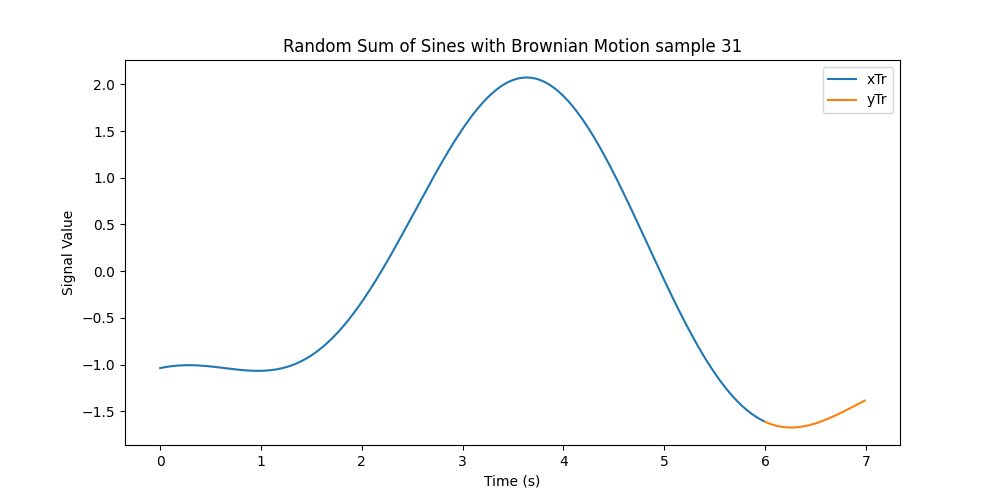

In [22]:
def train_test_split(data, lookback_period, forecast_period, split = 0.2):
    nTr = int(data.shape[0]*(1-split)) # number of training samples
    xTr = data[:nTr,:lookback_period]
    yTr = data[:nTr,lookback_period:]
    xTe = data[nTr:,:lookback_period]
    yTe = data[nTr:,lookback_period:]

    return xTr, yTr, xTe, yTe

xTr,yTr,xTe,yTe = train_test_split(data=data,lookback_period=lookback,forecast_period=forecast,split = 0.2)

# # Check the split is correct:
# random_sample = np.random.randint(0,200)

# plt.figure(figsize=(10, 5))
# plt.plot(np.arange(lookback) * delta_t, xTr[random_sample], label='xTr')
# plt.plot(np.arange(lookback,timesteps) * delta_t, yTr[random_sample], label='yTr')
# plt.xlabel("Time (s)")
# plt.ylabel("Signal Value")
# plt.title(f"Random Sum of Sines with Brownian Motion sample {random_sample}")
# plt.legend()
# plt.show()